# 4D-Variational Data Assimilation for a Chaotic Dynamical System

In this tutorial, you will learn how to use differentiable Tesseracts to implement a 4D-Var data assimilation scheme for a chaotic dynamical system, which includes using Tesseracts in an optimization context and embedding them into other (differentiable) Python / JAX code. 

We will use the [Lorenz 96](https://en.wikipedia.org/wiki/Lorenz_96_model) model as our dynamical system and demonstrate how to combine model forecasts with observations to produce an optimal estimate of the state of the system over a time window.

## Context
Here we walk throught a simple, hands-on demo of [four-dimensional variational data assimilation](https://www.ecmwf.int/en/newsletter/175/earth-system-science/linearised-physics-heart-ecmwfs-4d-var) -- sometimes called 4D-Var -- using a classic chaotic system.

4D-Var is a powerful technique for combining model forecasts with observations to produce an optimal estimate of the state of a dynamical system over a time window. It is widely used in meteorology, oceanography, and other fields where accurate state estimation is crucial.

It is also a great fit for Tesseracts:
- **Separation of model and optimization** --- Tesseracts allow us to define the model as a separate component from the optimization process, making it easy to swap out different models or modify the model without changing the optimization code.
- **Autodiff capabilities** --- 4D-Var is a variational method, which means it can be expressed as an optimization problem that minimizes a cost function. Since Tesseracts expose their derivatives, we can easily compute gradients of the cost function with respect to the model state and parameters.
- **JAX interoperability** --- Tesseracts play well with [JAX](https://github.com/jax-ml/jax), which provides powerful tools for automatic differentiation and GPU/TPU acceleration. This allows us to efficiently compute gradients and perform optimization on large-scale problems. 

## Problem setup

We’ll use data from a two-scale Lorenz 96 system, which describes two sets of variables operating on different scales, but run a simpler, single-scale Lorenz 96 solver as our surrogate model. That is, we will use a model that we know is incorrect to illustrate how 4D-Var can still produce useful results even when the model does not perfectly match the true system.

**Two‐scale Lorenz 96**  

The true system couples each slow variable $x_i$ with $J$ fast variables $y_{j,i}$ through the following set of ordinary differential equations:

$$
\frac{dx_i}{dt}
= (x_{i+1} - x_{i-2})\,x_{i-1}
- x_i
+ F
- \frac{h\,c}{b}\sum_{j=1}^{J}y_{j,i},
$$

$$
\frac{dy_{j,i}}{dt}
= c\,b\,(y_{j+1,i} - y_{j-2,i})\,y_{j-1,i}
- c\,y_{j,i}
+ \frac{h\,c}{b}\,x_i,
$$

where $F$ is the external forcing, $h$ controls the coupling strength, $c$ is the slow/fast time‐scale ratio, and $b$ sets the fast‐variable amplitude. For the true system, we use $h=1$, $b=10$, $c=10$, and $F=18$. 

The fast variables in the true system have small amplitude yet are essential for accurate forecasts—just as in many multi‐scale or multi‐physics problems. Because limited computational power and imperfect knowledge prevent fully resolving small‐scale, fast processes in real science and engineering simulations, we instead employ a simplified, reduced‐order model -- in this case the single‐scale Lorenz system—to approximate the true dynamics.

**Single‐scale Lorenz 96**  

For $i=1,\dots,N$ (with cyclic indices $x_{i+N}=x_i$):

$$
\frac{dx_i}{dt}
= (x_{i+1} - x_{i-2})\,x_{i-1}
- x_i
+ F,
$$

where $N$ is the number of slow variables. We can augment the reduced-order model by adding an empirical correction term as a function of the reduced-order model states to partially compensate for the missing dynamics; however, since the true fast processes obey their own ODEs, this closure remains approximate and cannot fully eliminate model error. In complex nonlinear systems, these small model errors amplify rapidly -- much like weather forecasts lose skill beyond a few days -- so the predicted state inevitably degrades over time.

Now, let’s have a look at how an imperfect model can deviate from the truth.

In [3]:
# Install additional packages
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


## Step 1: Build and serve the single-scale Lorenz 96 Tesseract

We implement a simple JAX model in the `lorenz_tesseract` folder (see 
[docs](lorenz_tesseract.md)). The `apply` function returns a trajectory of physical states given an initial condition:

```python
def lorenz96_multi_step(
    state: jnp.ndarray, F: float, dt: float, n_steps: int
) -> jnp.ndarray:
    """Perform multiple steps of Lorenz 96 integration using scan."""

    def step_fn(state: jnp.ndarray, _: Any) -> tuple:
        return lorenz96_step(state, F, dt), state

    _, trajectory = jax.lax.scan(step_fn, state, None, length=n_steps)
    return trajectory
```


We use the `tesseract build` command to build the Tesseract into a Docker image, which we can then run as a service.

In [5]:
%%bash
tesseract build lorenz_tesseract/

 [i] Building image ...
⠋ Processing
 [i] Built image sha256:82371ea43228, ['lorenz:latest']


["lorenz:latest"]


In [6]:
# Start a server container to interact with the Tesseract.
from tesseract_core import Tesseract

lorenz_tesseract = Tesseract.from_image("lorenz")
lorenz_tesseract.serve()

## Step 2: Load the ground truth data

[This](https://github.com/pasteurlabs/tesseract-core/blob/main/demo/data-assimilation-4dvar/lorenz96_two_scale_F_18_sample_0_small.npz) is the data we will use to perform the 4D-Var assimilation. The ground truth is generated by integrating the two-scale Lorenz 96 system with a known initial condition and parameters.

In [7]:
import numpy as np

X_states = np.load("lorenz96_two_scale_F_18_sample_0_small.npz")["X_states"]
t = np.load("lorenz96_two_scale_F_18_sample_0_small.npz")["t"]

## Step 3: Forward evaluation with Tesseract, create observations

Let's use our imperfect surrogate to perform a simulation from the true intial condition. We will set the forcing term $F=18$, and we use $dt=0.005$ for numerical integration.

In [8]:
import jax.numpy as jnp

static_params = {
    "F": 18.0,
    "dt": 0.005,
    "n_steps": 2000,
}

# remove the first 500 time steps to avoid transients
true_trajectory = X_states[500:]
X0 = true_trajectory[0]


def lorenz_tesseract_fn(x0: jnp.ndarray) -> jnp.ndarray:
    """Forward operator that integrates the Lorenz 96 system using a surrogate model.

    Args:
        x0: Initial state vector of the Lorenz 96 system

    Returns:
        Complete trajectory of the system state after time integration
    """
    return lorenz_tesseract.apply(
        inputs=dict(state=x0, **static_params),
    )


pred = lorenz_tesseract_fn(X0)["result"]

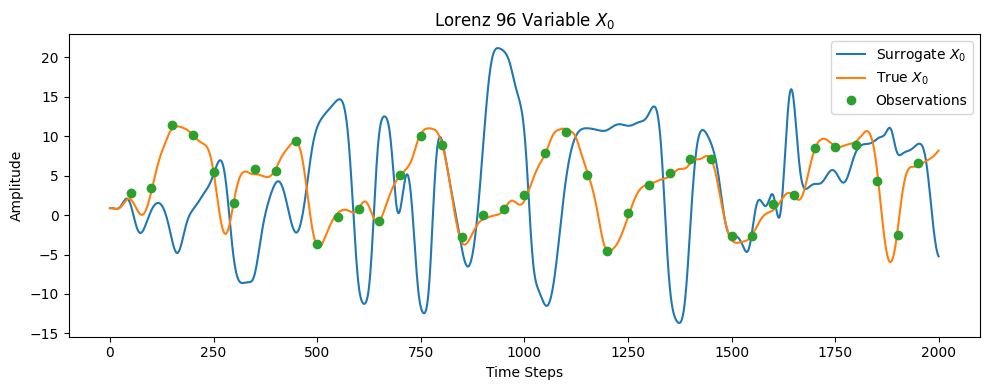

In [30]:
import jax
import matplotlib.pyplot as plt

H = jnp.eye(8)  # observe all variables

# Create synthetic observations
key = jax.random.PRNGKey(0)

# time step between observations
obs_gap = 50
time_obs = jnp.arange(obs_gap, len(true_trajectory), obs_gap)
obs = true_trajectory[obs_gap::obs_gap]
obs = jax.vmap(lambda row: H @ row)(obs)

# Observation error covariance matrix
std_obs = 0.5
R = std_obs**2 * jnp.eye(obs.shape[1])
sqrt_s = jnp.sqrt(R)
noise = jax.random.normal(key, obs.shape) @ sqrt_s
obs = obs + noise

# visualize the first slow variable
pos = 0
plot_end = 2000
plot_obs_end = plot_end // obs_gap
plt.figure(figsize=(10, 4))
plt.plot(pred[:plot_end, pos], label="Surrogate $X_0$")
plt.plot(true_trajectory[:plot_end, pos], label="True $X_{0}$")
plt.plot(time_obs[:plot_obs_end], obs[:plot_obs_end, pos], "o", label="Observations")

plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
plt.title("Lorenz 96 Variable $X_0$")
plt.legend()
plt.tight_layout()
plt.show()

With an imperfect surrogate, the model’s trajectory only remains close to the true system for a short time. But fortunately, we have real observations! Balloon soundings, satellite measurements, and the like—that, despite being noisy and sparse, still provide invaluable information. 4D-Var is a data-assimilation technique that blends these observations with our model forecasts to yield a more accurate state estimate, which then initializes the next forecast cycle.

This is the same approach [used operationally at the European Centre for Medium-Range Weather Forecasts](https://www.ecmwf.int/en/about/media-centre/news/2017/20-years-4d-var-better-forecasts-through-better-use-observations#:~:text=8%20years%20old.-,20%20years%20of%204D%2DVar%3A%20better%20forecasts%20through,a%20better%20use%20of%20observations&text=Twenty%20years%20ago%20ECMWF%20added,improvements%20in%20the%20Centre's%20forecasts.), one of the world’s premier weather-prediction centres.


## Step 4: 4D-Var data assimilation

In this section, we will implement the 4D-Var algorithm to assimilate the observations into our model. The goal is to find an initial condition that minimizes the difference between the model trajectory and the observations over a given time window.

### Introduction to the 4D-Var method

<div class=admonition note alert alert-warning>
<p class=admonition-title>Note</p>
    
You can skip this section if you wish -- all you need to know for the purpose of this tutorial is that 4D-Var can be represented as an optimization problem that minimizes a cost function over a time window, using the model to propagate the state forward in time. But if you want to understand the method in more detail, read on!
</div>


Given an imperfect forecast $\mathbf{x}^b$ (background), 4D-Var finds the initial state $\mathbf{x}_0$ that minimizes

$$
J(\mathbf{x}_0)
= \frac{1}{2}(\mathbf{x}_0 - \mathbf{x}^b)^\top \mathbf{B}^{-1} (\mathbf{x}_0 - \mathbf{x}^b)
\;+\;
\frac{1}{2}
\sum_{i=0}^{n_{\mathrm{obs}}-1}
\bigl(\mathbf{y}_i - \mathbf{H}\,\mathbf{x}_i\bigr)^\top
\mathbf{R}^{-1}
\bigl(\mathbf{y}_i - \mathbf{H}\,\mathbf{x}_i\bigr),
$$

subject to

$$
\mathbf{x}_i =
\begin{cases}
\mathbf{x}_0, & i = 0,\\
\mathcal{M}(\mathbf{x}_{i-1}), & i = 1,\dots,n_{\mathrm{obs}}-1.
\end{cases}
$$

**Definition of symbols**  
- $\mathbf{x}_0\in\mathbb{R}^n$: the **analysis** (initial) state vector at the start of the window.  
- $\mathbf{x}^b\in\mathbb{R}^n$: the **background** or first-guess state (short-range forecast).  
- $\mathbf{B}\in\mathbb{R}^{n\times n}$: background-error covariance matrix.  
- $n_{\mathrm{obs}}$: number of observation times in the assimilation window.  
- $\mathbf{y}_i\in\mathbb{R}^m$: observation vector at time $t_i$.  
- $\mathbf{H}\in\mathbb{R}^{m\times n}$: (linearized) observation operator mapping state $\mathbf{x}_i$ to observation space.  
- $\mathbf{R}\in\mathbb{R}^{m\times m}$: observation-error covariance matrix.  
- $\mathcal{M}:\mathbb{R}^n\to\mathbb{R}^n$: nonlinear forecast model operator advancing the state from $t_{i-1}$ to $t_i$.  
- $\mathbf{x}_i$: model state at time $t_i$, with $\mathbf{x}_0$ as the control variable and $\mathbf{x}_i = \mathcal{M}(\mathbf{x}_{i-1})$ thereafter.  
- $i$: index for observation times, ranging from 0 to $n_{\mathrm{obs}}-1$.


#### What is being minimized?


1. **Observation‐misfit**

   $$
   \frac{1}{2}
   \sum_{i=0}^{n_{\mathrm{obs}}-1}
   \bigl(\mathbf{y}_i - \mathbf{H}\,\mathbf{x}_i\bigr)^\top
   \mathbf{R}^{-1}
   \bigl(\mathbf{y}_i - \mathbf{H}\,\mathbf{x}_i\bigr)
   $$

   Enforces agreement with all observations, weighted by the observation‐error covariance $\mathbf{R}$. However, real observations are always sparse and noisy, so minimizing this term alone is ill‐conditioned and admits infinitely many solutions.

2. **Background‐misfit**  
   
   $$
   \frac{1}{2}(\mathbf{x}_0 - \mathbf{x}^b)^\top \mathbf{B}^{-1} (\mathbf{x}_0 - \mathbf{x}^b)
   $$

   Penalizes deviations from the imperfect forecast, scaled by the background‐error covariance $\mathbf{B}$. This term also acts as a regularizer, making the overall optimization well‐posed.


#### Why not simply re-initialize the model with observations?

There are many reasons -- here are two of them:
- **Noisy and sparse observations.** Direct insertion of $\mathbf{y}$ injects noise and leaves unobserved components unconstrained.  
- **Temporal smoothing.** 4D-Var distributes corrections over the entire window, yielding a dynamically consistent analysis that tries to satisfy both model physics and all observations.


### 4D-Var implementation

In [10]:
# idealized error convariance matrices
B_inv = jnp.eye(8)
R_inv = jnp.linalg.inv(R)

In [11]:
# Create 6 groups of 3 observations
n_obs = 3
obs_trajs = [obs[i : i + n_obs] for i in range(0, 19, n_obs)]

In [12]:
params_window = {
    "F": 18.0,
    "dt": 0.005,
    "n_steps": obs_gap * n_obs,
}


def M_window(x: jnp.ndarray) -> jnp.ndarray:
    """Forward operator integrating Lorenz 96 over an entire assimilation window.

    Args:
        x: Initial state vector at the beginning of the assimilation window

    Returns:
        Complete trajectory spanning the entire assimilation window
    """
    return lorenz_tesseract.apply(
        inputs=dict(state=x, **params_window),
    )

We implement the optimization algorithm using SciPy and JAX. That is, we define the cost function $J(\mathbf{x}_0)$ and use JAX's automatic differentiation to compute the gradient with respect to the initial state $\mathbf{x}_0$.

We then use an optimization algorithm that leverages these gradients (e.g., L-BFGS) to minimize the cost function.

In [13]:
import scipy


def analysis_4DVar(
    xb: jnp.ndarray,
    y: jnp.ndarray,
    M: callable,
    H: jnp.ndarray,
    R_inv: jnp.ndarray,
    B_inv: jnp.ndarray,
    n_obs: int = 3,
) -> jnp.ndarray:
    """Perform four-dimensional variational data assimilation analysis.

    Args:
        xb: Background state vector serving as the first guess
        y: Observation vector containing measurements at multiple time steps
        M: Forward model operator for time integration between observations
        H: Linear observation operator mapping model space to observation space
        R_inv: Inverse observation error covariance matrix
        B_inv: Inverse background error covariance matrix
        learning_rate: Step size for Adam optimizer
        max_iter: Maximum number of optimization iterations
        n_obs: Number of observation times within the assimilation window

    Returns:
        Optimal analysis state minimizing the 4D-Var cost function
    """

    @jax.jit
    def cost_fn(x0: jnp.ndarray) -> jnp.ndarray:
        """Compute the 4D-Var cost function with background and observation terms.

        Evaluates the standard 4D-Var objective function J = J_b + J_o, where J_b
        penalizes departure from background and J_o penalizes observation misfits
        across the assimilation window.

        Args:
            x0: Initial state vector for cost evaluation

        Returns:
            Total cost function value combining background and observation terms
        """
        J_b = 0.0
        J_o = 0.0

        # Background term
        background_diff = x0 - xb
        J_b = 0.5 * jnp.dot(background_diff, B_inv @ background_diff)

        # Observation terms across assimilation window
        current_state = x0
        obs_diff = y[0] - H @ current_state
        J_o += 0.5 * jnp.dot(obs_diff, R_inv @ obs_diff)

        for i in range(1, n_obs):
            current_state = M(current_state)["result"][-1]
            obs_diff = y[i] - H @ current_state
            J_o += 0.5 * jnp.dot(obs_diff, R_inv @ obs_diff)

        return J_b + J_o

    x0 = scipy.optimize.minimize(
        cost_fn, xb, method="L-BFGS-B", jac=jax.grad(cost_fn)
    ).x
    return x0

But wait! Our model is a Tesseract, which is not natively compatible with JAX's automatic differentiation. So we need to wrap the Tesseract in a JAX-compatible function that can be differentiated, by registering a JAX custom derivative for the Tesseract's `apply` method, via [`jax.pure_callback`](https://docs.jax.dev/en/latest/_autosummary/jax.pure_callback.html) and [`jax.custom_vjp`](https://docs.jax.dev/en/latest/_autosummary/jax.custom_vjp.html).

<div class=admonition note alert alert-warning>
<p class=admonition-title>Note</p>

While this works in this example, registering Tesseracts by hand is not the recommended way to use Tesseracts in JAX. Instead, you should check out [Tesseract-JAX](https://github.com/pasteurlabs/tesseract-jax), which automatically registers Tesseracts as JAX-compatible functions, allowing you to use them seamlessly in JAX code without needing to manually define callbacks or register custom derivatives.
</div>

In [14]:
from typing import Any

# Construct the forward operator using tesseract to integrate the system until next observation is available
params_M = {
    "F": 18.0,
    "dt": 0.005,
    "n_steps": obs_gap,
}


def convert_jax_to_python(inputs_dict: dict[str, Any]) -> dict[str, Any]:
    """Convert JAX arrays back to Python types for tesseract API.

    Args:
        inputs_dict: Dictionary potentially containing JAX arrays.

    Returns:
        Dictionary with JAX scalars converted to Python types while preserving
        JAX arrays for state variables.
    """
    converted = {}
    for key, value in inputs_dict.items():
        if key == "state":
            converted[key] = value  # Keep state as JAX array
        elif hasattr(value, "item"):
            converted[key] = value.item()  # Convert JAX scalars to Python types
        else:
            converted[key] = value
    return converted


@jax.custom_vjp
def M(x: jnp.ndarray) -> dict[str, jnp.ndarray]:
    """Forward operator integrating Lorenz 96 for n_steps.

    Args:
        x: Initial state vector of shape (8,).

    Returns:
        Dictionary containing trajectory of shape (n_steps, 8) under 'result' key.
    """
    n_steps = params_M["n_steps"]
    result = jax.pure_callback(
        lambda inputs: lorenz_tesseract.apply(inputs=convert_jax_to_python(inputs)),
        {"result": jax.ShapeDtypeStruct((n_steps, x.shape[0]), x.dtype)},
        dict(state=x, **params_M),
    )
    return result


def M_fwd(x: jnp.ndarray) -> tuple[dict[str, jnp.ndarray], jnp.ndarray]:
    """Forward pass for custom VJP returning result and residuals.

    Args:
        x: Initial state vector of shape (8,).

    Returns:
        Tuple containing:
            - Dictionary with trajectory under 'result' key
            - Residuals (initial state) for backward pass
    """
    return M(x), x


def M_bwd(
    residuals: jnp.ndarray, cotangents: dict[str, jnp.ndarray]
) -> tuple[jnp.ndarray]:
    """Backward pass computing vector-Jacobian product.

    Args:
        residuals: Stored initial state from forward pass.
        cotangents: Gradient vector with same structure as forward output.

    Returns:
        Tuple containing gradient with respect to initial state of shape (8,).
    """
    x = residuals
    cotangents_result = cotangents["result"]

    grad_x = jax.pure_callback(
        lambda inputs, cot_vec: lorenz_tesseract.vector_jacobian_product(
            inputs=convert_jax_to_python(inputs),
            vjp_inputs=["state"],
            vjp_outputs=["result"],
            cotangent_vector=cot_vec,
        ),
        jax.ShapeDtypeStruct(x.shape, x.dtype),
        dict(state=x, **params_M),
        {"result": cotangents_result},
    )
    return (grad_x,)


M.defvjp(M_fwd, M_bwd)

### Application of the 4D-Var method to the Lorenz 96 model

In [15]:
# integrate to first observation
history = []
X_pred = jnp.zeros((obs_gap + 1, X0.shape[0]))
X_pred = X_pred.at[0].set(X0)
Xf = M(X0)["result"]
X_pred = X_pred.at[1:].set(Xf)
Xb = Xf[-1]
history.append(X_pred)

Now we run the cyclic forecast-assimilation.

In [16]:
for obs_traj in obs_trajs[:3]:
    print("Now assimilating observations:", obs_traj)
    X0 = analysis_4DVar(Xb, obs_traj, M, H, R_inv, B_inv, n_obs=n_obs)

    # forecast step
    print("Forecasting next assimilation window...")
    X_pred = jnp.zeros((n_obs * obs_gap + 1, X0.shape[0]))
    X_pred = X_pred.at[0].set(X0)
    Xf = M_window(X0)["result"]
    X_pred = X_pred.at[1:].set(Xf)
    Xb = Xf[-1]

    history.append(X_pred)

Now assimilating observations: [[ 2.799733    9.399986    0.46893954 -2.4860692   1.3382943  12.572049
   3.3946197  -3.8351834 ]
 [ 3.379249    8.853455    2.9171748   0.03306353  3.867188   11.950285
  -0.8432639   3.8301866 ]
 [11.4476185   0.6421503  -1.4374818   1.4826026   9.486775    7.7398486
  -1.7716159   5.5438924 ]]
Forecasting next assimilation window...
Now assimilating observations: [[10.179231   -0.24670759  5.3289804  10.904022    4.2516203  -5.7708306
   0.8604067   5.689573  ]
 [ 5.4109397  -1.3887025   5.18376     8.259685   -3.789405    4.848869
   6.546297    8.800019  ]
 [ 1.5806762   1.6670504   7.6248302   6.626485   -0.29925     5.1062775
  11.641597   -5.082076  ]]
Forecasting next assimilation window...
Now assimilating observations: [[ 5.8376927 12.217752   0.9033669 -0.9313403  1.507611   8.427427
   6.484769  -1.1838636]
 [ 5.5618935 10.293968  -1.5365992  4.548709   9.417823   4.735697
  -3.5575433  1.5427291]
 [ 9.448657   2.7177422 -1.634881   6.214278

### Visualize results

In [17]:
def get_da_res(forecast_list: list) -> jnp.ndarray:
    """Get the DA results from a list of forecasts.

    Args:
        forecast_list: List of forecasts.

    Output:
        concatenated_forecasts: Concatenated forecasts.
    """
    processed_forecasts = []

    for forecasts in forecast_list:
        # Remove the last time step from each trajectory
        trimmed_forecasts = forecasts[:-1, :]  # Shape (Ne, Nt, nx)
        processed_forecasts.append(trimmed_forecasts)

    # Concatenate all processed forecasts along the time dimension
    concatenated_forecasts = jnp.concatenate(processed_forecasts, axis=0)

    return concatenated_forecasts

In [18]:
x4DVar = get_da_res(history)

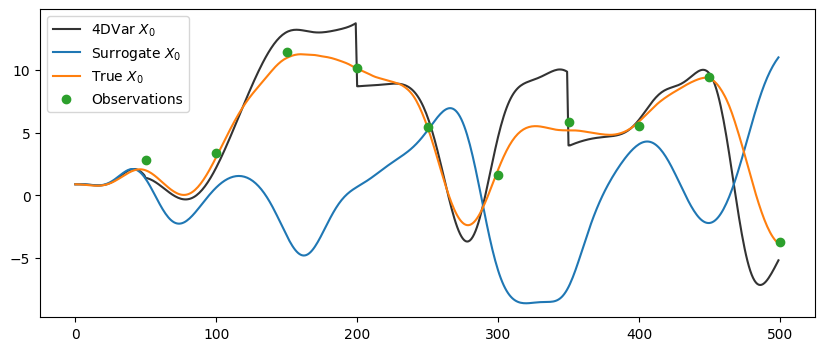

In [29]:
# Visualize the results
pos = 0
plot_end = 500
plot_obs_end = plot_end // obs_gap
plt.figure(figsize=(10, 4))
plt.plot(x4DVar[:plot_end, pos], label=f"4DVar $X_{pos}$", color=".2")
plt.plot(pred[:plot_end, pos], label=f"Surrogate $X_{pos}$")
plt.plot(true_trajectory[:plot_end, pos], label=f"True $X_{pos}$")
plt.plot(time_obs[:plot_obs_end], obs[:plot_obs_end, pos], "o", label="Observations")
plt.legend(loc="upper left")

The black curve, after running 4D-Var, hugs the orange “true” line much more closely. You can see at steps 50, 200, and 350 (where we perform 4D-Var with following 3 observations) that analysis pulls the model back toward the true state, even though we're not even modelling the same system that the true data was generated from. Data assimilation keeps us on track for far longer than just letting the imperfect model run free.

In [20]:
# Tear down Tesseract after use to prevent resource leaks
lorenz_tesseract.teardown()

## And that's it! 

We have implemented our Lorenz-96 solver in **Tesseract** using **JAX**, which gives us full separation of concerns and automatic differentiation. This lets us directly compute gradients of the 4D-Var cost function and perform gradient-based optimization end-to-end, without any manual gradient coding.

So we can better appreciate the advantages of built-in automatic differentiation, here's how operational weather centers tackle 4D-Var data assimilation.

**Traditional numerical weather prediction (mostly Fortran, no autodiff)** ([example](https://www.ecmwf.int/en/newsletter/175/earth-system-science/linearised-physics-heart-ecmwfs-4d-var)):

- Requires to manually derive and implement tangent-linear approximation and adjoint routines for every physical processes (radiation, convection, orographic drag, etc.) for gradient computing.  
- Writing, testing and maintaining those adjoints is a massive, decades-long effort—and it never really ends.  
- Every time you tweak or add a new physical processes, you have to derive and code its tangent-linear/adjoint from scratch.  
- Subtle mismatches between forward and adjoint code can sneak in.

Now contrast this with our approach here.

**Differentiable model with JAX and Tesseract**:

- Gradients are automatic -- JAX traces the whole nonlinear model, so we don’t write a single tangent-linear model/adjoint by hand.  
- We hook directly into familiar ML optimizers (SGD, Adam, etc.), making experimentation quick and painless.  
- Adding new physics or parameterizations is as simple as dropping them into the code -- JAX takes care of all derivatives.  
- One code path runs forward and backward, so analyses stay consistent and debugging is far easier.  